In [ ]:
# %pip install gymnasium
# %pip install numpy
# %pip install matplotlib

In [1]:
import gymnasium as gym
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from IPython.display import Image

## random policy

- Equal probability for selecting any action in any state

In [3]:
def random_policy(nS,nA):
    action_prob = [1/nA] * nA
    return [action_prob for _ in range(nS)]

## greedy policy

- Always select the action with the highest Q-value (predicted future reward) for the current state to exploit 

In [4]:
def greedy_policy(Q, nS, nA):
    # initialize arbitrary policy
    policy = np.zeros([nS,nA])
    
    # list of states in environment 
    S = [i for i in range(nS)]

    # loop over states
    for state in S:
        if all([ q == 0 for q in Q[state]]) :
            policy[state] = random_policy(1,nA)[0]
        
        else:
            best_action = np.argmax(Q[state]) 
            policy[state] = np.eye(nA)[best_action].tolist()

    return policy

## ε-greedy policy

- Initialize the exploration rate ε
- Generate a random number between 0 and 1.
- If the generated random number is less than ε, select a random action to explore.
- Otherwise, select the action with the highest Q-value for the current state to exploit.

In [5]:
def epsilon_greedy_policy(Q, nS, nA, epsilon):
    # initialize arbitraty policy
    policy = [[0 for _ in range(nA)] for _ in range (nS)]
    
    # list of states in environment 
    S = [i for i in range(nS)]

    # list of possible actions to be taken by the agent
    A = [i for i in range(nA)]

    # loop over states
    for state in S:

        # if all Q values in state are 0, agent picks random action
        if all([ q == 0 for q in Q[state][:]]):
            for action in range(nA):
                policy[state][action] = 1/nA

        else:
            # position of maximum Q value in state
            maxQ = np.argmax(Q[state])

            # probability agent acts randomly
            prob = [epsilon/nA for _ in range(nA)]

            # probability agent acts greedily
            prob[maxQ] = 1 - epsilon  + (epsilon/nA)

            for action in A:
                policy[state][action] = prob[action]
    return policy

Function to evaluate policy performance
----------------------------------------

- Evaluate average episode reward following a given policy 

In [6]:
def evaluate_average_reward(env, nA, policy, num_eval_episodes = 100):
    # store episode rewards 
    episode_rewards = []

    # list of possible actions to be taken by the agent
    A = [i for i in range(nA)]
    
    # loop over number of episodes 
    for _ in range(num_eval_episodes):
        state = env.reset()[0]
        episode_reward = 0

        # loop until episode ends
        while True:
            # pick action according to the current policy
            action = random.choices(A, weights=[policy[state][i] for i in range(nA)], k=1)[0]

            # take action
            next_state, reward, terminated, truncated, info = env.step(action)

            # update current state
            state = next_state

            # count cumulative episode reward:
            episode_reward += reward
        
            # exit loop when episode is terminated or truncated
            if terminated==True or truncated == True:
                episode_rewards.append(episode_reward)
                break
    
    env.reset()
    
    reward_average = np.mean(episode_rewards)

    return reward_average

Frozen Lake environment from gymnasium API
--------------------------------------------

In [7]:
env = gym.make('FrozenLake-v1',map_name="4x4",render_mode="ansi",is_slippery=False)

# restart episode with agent in state 0
next_state, info = env.reset()

print(env.render())

nS = env.observation_space.n
nA = env.action_space.n

print(f"Size of state space: {nS} \nSize of action space: {nA}")


SFFF
FHFH
FFFH
HFFG

Size of state space: 16 
Size of action space: 4


On-policy MC control
----------------------
---------------------

Monte Carlo methods are a type of model-free algorithms that find optimial policies for environments where the dynamics, p(s',r|s,a), are not known. In order to learn the optimal actions for control, MC methods estimates action-value functions by averaging over sample returns.

The MC algorithm generates episodes (a series of states, actions and rewards until a terminal state is reached) following a given policy. The algorithm updates state-action values only for first-time state-action pairs in an episode. As returns for a state is the sum of future discounted rewards, updates of state-values are evaluated by looping backwards from the end of the episode. For an optimial control policy, we then just select the action in a given state that maximises the state-action value function. Here we use epsilon-greedy policy to encourage exploration as well as exploitation.

on-policy MC control algorithm:


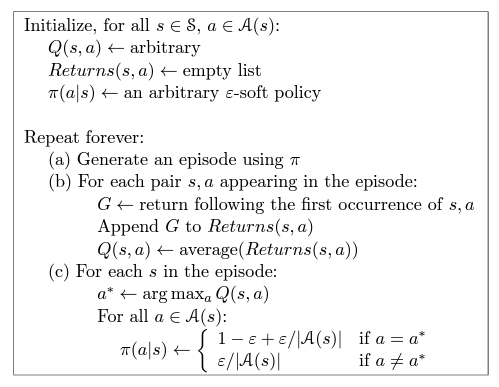

In [3]:
print("on-policy MC control algorithm:")
Image(filename='Pseudo-code/on-policy_MC_control.png')

Set hyperparameters

In [ ]:
# Discount factor [0,1]
gamma = # ...
# Exploration rate [0,1]
epsilon = # ...
# Number of episodes [1,infty]
num_episodes = # ...

In [ ]:
def onpolicy_control(env, nS, nA, num_episodes, gamma, epsilon):
    # initialize arbitrary action-value function
    Q = #...

    # list of possible actions to be taken by the agent
    A = [i for i in range(nA)]

    # initialize list to save state-action returns for each epsisode
    returns = [[[] for _ in range(nA)] for _ in range(nS)]

    # intialise epsilon-greedy policy
    policy = #...

    average_reward = evaluate_average_reward(env, nA, policy, num_eval_episodes = 100)
    
    # store number of policy iterations and average episode reward during training
    num_policy_iter = [0]
    average_rewards_list = [average_reward]

    # number of policy iterations
    n = 0

    # loop over number of episodes of experience sampled by agent 
    for _ in range(num_episodes):
        n+=1
        # initialize initial state value
        state = 0 
        
        # save states, actions and rewards for each episode
        states = [0]
        actions = []
        rewards = []

        # loop until episode terminates or truncates 
        while True:
            # epislon greedy policy
            policy = epsilon_greedy_policy(Q, nS, nA, epsilon = 0.1)
            
            # pick action according to the current policy
            action = #...

            # take action
            next_state, reward, terminated, truncated, info = env.step(action)
            
            if terminated == False and truncated == False:
                # save state, action and reward in episode

                # update current state
                state = next_state

            # if epsiode terminates or truncates,  and exit loop
            if terminated == True or truncated == True:
                actions.append(action)
                rewards.append(reward)

                # reset episode
                # exit loop
                
        # initialize return value: the total discounted award reward from a complete episode
        G = 0

        episode_length = len(states)

        state_action = [[states[i],actions[i]] for i in range(episode_length)]
        
        # evaluate return for each state in episode
        # loop backwards from the end of the episode, as return is a function of all future rewards in an episode
        for i in reversed(range(episode_length)):
            # return at the current state-action pair is equal to the sum of the immediate reward plus the future discounted return
            G = # ...

            # first-visit MC averages averages over returns from first state-action pair in an episode
            # ignore returns from state-action pairs after first time in epsiode
            if state_action[i] not in state_action[:i]:
                returns[states[i]][actions[i]].append(G)

                # evaluate state-action-value by taking the average of the state-action returns across all episodes of experience
                Q[states[i],actions[i]]= # ...
        
        # update policy 
        policy = # ...

        # save number of policy iterations
        num_policy_iter.append(n)

        # evaluate average episode reward
        average_reward = evaluate_average_reward(env, nA, policy, num_eval_episodes = 100)
        average_rewards_list.append(average_reward)

    return Q, policy, num_policy_iter, average_rewards_list

In [ ]:
Q, policy, num_policy_iter, average_rewards_list = onpolicy_control(env, nS, nA, num_episodes, gamma, epsilon)

Evaluate the results
--------------------

In [ ]:
# plot learning rate
fig, ax = plt.subplots()
ax.plot(num_policy_iter, average_rewards_list, color = 'black', label = "")

ax.set_xlabel("Number of policy iterations")
ax.set_ylabel('Average reward')

ax.legend(prop = { "size": 10 })

plt.xticks(np.arange(num_policy_iter[0], num_policy_iter[-1]+1,  num_policy_iter[-1]*0.1))

plt.show()

In [ ]:
# plot learning rate
fig, ax = plt.subplots()
ax.plot(num_policy_iter, average_rewards_list_b, color = 'black', label = "behaviour policy")
ax.plot(num_policy_iter, average_rewards_list_t, color = 'red', linestyle = 'dashed', label = "target policy")

ax.set_xlabel("Number of policy iterations")
ax.set_ylabel('Average reward')

ax.legend(prop = { "size": 10 })

plt.xticks(np.arange(num_policy_iter[0], num_policy_iter[-1]+1,  num_policy_iter[-1]*0.1))

plt.show()